In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True

In [2]:
device 

device(type='cuda')

In [4]:
patch_size = 8
embedding_dim = 64 

In [31]:
patches = data.unfold(1, patch_size, patch_size)
patches.shape

torch.Size([1, 56, 8])

In [32]:
linear_embedding = nn.Linear(patch_size, embedding_dim)
embedded_patches = linear_embedding(patches)


In [71]:
def try_fun(patch:int,embedded_size:int, data:float):
    
    data=data.unsqueeze(0)
    p=data.unfold(1,patch,patch)
    print(p.shape)
    linear_embedding1= nn.Linear(patch,embedded_size,dtype=torch.float64)
    return F.relu(linear_embedding1(p))

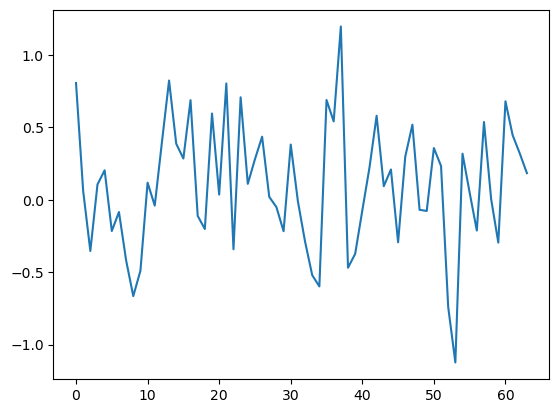

In [72]:
plt.plot(range(0,len(embedded_patches.detach().numpy()[0,1])),embedded_patches.detach().numpy()[0,1])
plt.show()

In [73]:
#import data
df=pd.read_csv('df_April_24_2023.csv')

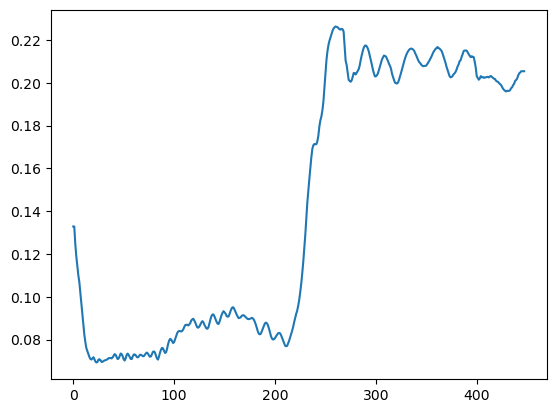

In [74]:
spectral=torch.from_numpy(df.iloc[1,31:].values.astype(float))
plt.plot(range(0,len(spectral.detach().numpy())),spectral.detach().numpy())

In [75]:
def show(data):
    plt.plot(range(0,len(data.detach().numpy()[0,2])),data.detach().numpy()[0,2])
    plt.show()

torch.Size([1, 28, 16])


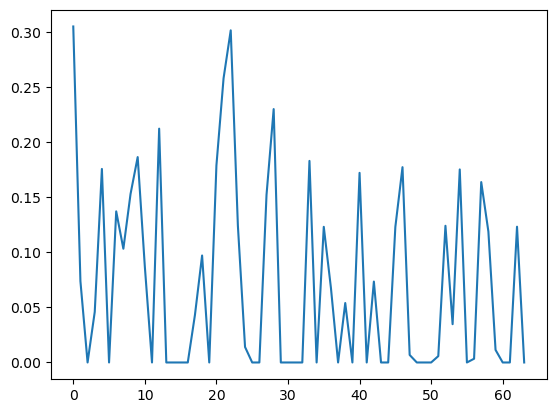

In [79]:
f1=try_fun(16,64,spectral)
show(f1)

In [80]:
len(spectral)//32

14

In [81]:
d=f1.detach().numpy().reshape(-1)

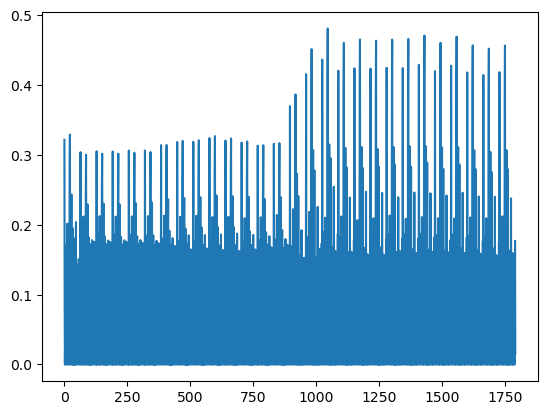

In [82]:
plt.plot(range(0,len(d)),d)

In [8]:
def transformation(r):
    return np.log(1/r)

def mean_center(data):
    new=data.copy()
    for i in range(data.shape[0]):
         new.iloc[i,:]= (data.iloc[i,:]-np.mean(data.iloc[i,:]))
    return new
        
def msc(input_data,reference=None):
    eps=np.finfo(np.float32).eps
    input_=np.array(input_data,dtype=np.float64)
    ref=[]
    sampleCount=int(len(input_))
    for i in range(input_data.shape[0]):
        input_[i,:]-=input_[i,:].mean()
    data_msc=input_data.copy()
    for i in range(input_.shape[0]):
        for j in range(0,sampleCount,10):
            ref.append(np.mean(input_[j:j+10],axis=0))
            fit=np.polyfit(ref[i],input_[i,:],1,full=True)
            data_msc.iloc[i,:]=(input_[i,:]-fit[0][1])/fit[0][0]
    
    return (data_msc)

def cls_convert(cls):
    if cls=="WW":
        return 0
    elif cls=="MS":
        return 1
    else:
        return 2

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
file_path = 'dataset/resampled.csv'

data = pd.read_csv(file_path)
#data['class_new']= data['class'].apply(cls_convert)

In [23]:
X = data.loc[:, "475":"751"]
y_class,y_reg=data.iloc[:,-1].values,data.iloc[:,-2].astype('float32').values
print(f'x= {X.shape}')
print(f'y_class= {y_class.shape}')
print(f'y_reg= {y_reg.shape}')

x= (809, 207)
y_class= (809,)
y_reg= (809,)


In [24]:
x_1=transformation(X)
x_2=msc(x_1)
x_3=mean_center(x_2)


<AxesSubplot:>

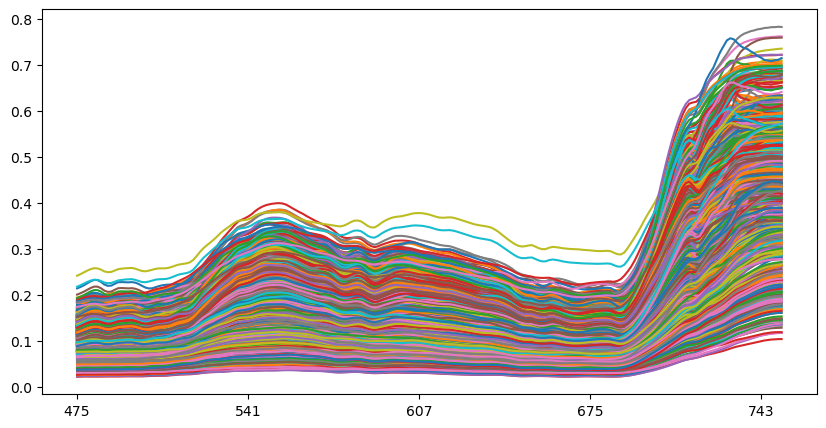

In [27]:
X.T.plot(legend=False,figsize=(10,5))

<AxesSubplot:>

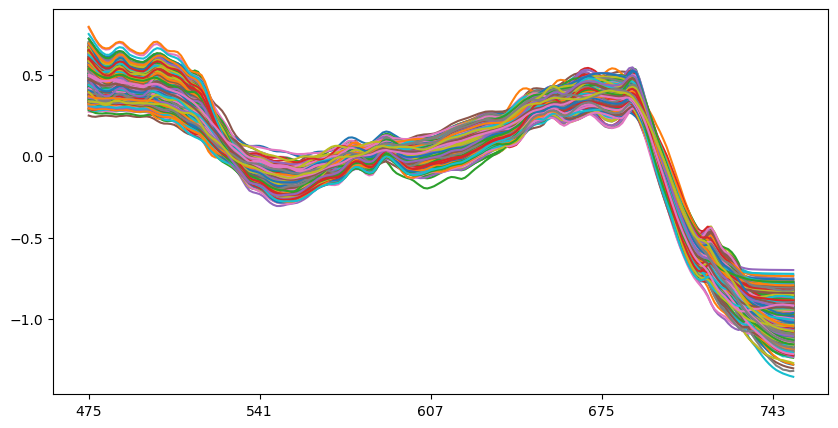

In [28]:
x_3.T.plot(legend=False,figsize=(10,5))

In [29]:
X_train, X_test, y_train_class,y_test_class,y_train_reg,y_test_reg = train_test_split(x_3, y_class,y_reg, test_size=0.2, random_state=42)

In [63]:
import torch
import torch.nn as nn
import math

class SpectralPatchEmbedding(nn.Module):
    '''
        Input: spectral data (1xm), m= bandwithrange
        output: Patched spectral data with new embedding. (Nxd), N= No of patches (m/patch_size),
                                                                d = embedding dimension 
    '''
    def __init__(self, patch_size, embedding_dim):
        super().__init__()
        self.patch_size = patch_size
        self.embedding = nn.Linear(patch_size, embedding_dim)

    def forward(self, x):
        
        x = x.unfold(2, self.patch_size, self.patch_size).contiguous()
        x = x.view(x.size(0), -1, self.patch_size)
        x = self.embedding(x)
        return x

class PositionalEncoding(nn.Module):
    
    '''
        Input: embedded spectral data (Nxd)
        output: embedded spectral data 
    '''
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return x

class FeatureExtractor(nn.Module):
    def __init__(self, num_features, patch_size, embedding_dim, num_heads, num_encoder_layers, dim_feedforward):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.patch_embedding = SpectralPatchEmbedding(patch_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward,activation='gelu'),
            num_layers=num_encoder_layers
        )

    def forward(self, inputs):
        batch_size=inputs.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        inputs = self.patch_embedding(inputs)
        print(f'cls_shape{cls_tokens.shape} ,input_shape{inputs.shape}')
        inputs = torch.cat((cls_tokens, inputs), dim=1)
        inputs = self.pos_encoder(inputs)
        output = self.transformer_encoder(inputs)
        return output
    
class ClassificationHead(nn.Module):
    def __init__(self, input_features, hidden_features, num_classes):
        """
        - input_features: int, number of input features from the feature extractor.
        - hidden_features: int, number of features in the hidden layer.
        - num_classes: int, number of output classes for classification.
        """
        super(ClassificationHead, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # First linear layer
        self.fc1 = nn.Linear(input_features, hidden_features)
        # Batch normalization for the hidden features
        self.bn1 = nn.BatchNorm1d(hidden_features)
        # Optional: Add dropout for regularization
        self.dropout = nn.Dropout(0.5)
        # Second linear layer, which outputs the class scores
        self.fc2 = nn.Linear(hidden_features, num_classes)
        
    def forward(self, x):

        # Average over the sequence dimension
        x = x.transpose(1, 2)  # Change shape to [batch_size, input_features, seq_len]
        x = self.avg_pool(x)  # Apply average pooling, resulting shape [batch_size, input_features, 1]
        x = x.squeeze(-1)  # Remove the last dimension, resulting shape [batch_size, input_features]
        x = self.fc1(x)  # Apply first linear layer
        x = self.bn1(x)  # Apply batch normalization
        x = F.relu(x)  # Apply ReLU activation function
        x = self.dropout(x)  # Apply dropout
        return self.fc2(x) #class
    

In [3]:
model = CombinedModel(num_features=448, patch_size=16, embedding_dim=128, num_heads=8, num_encoder_layers=6, dim_feedforward=2048,
                     hidden_features_class=128, num_classes=3, hidden_features_reg=128, output_features_reg=1, use_classification=True)
data = torch.rand((1,1, 448))
output = model(data)
cls=ClassificationHead(output.shape[1],10,3)
output=cls(output)
# print(cls.shape())
output.shape

NameError: name 'CombinedModel' is not defined

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

class SpectralPatchEmbedding(nn.Module):
    """
    Embeds spectral data into patches with a specified embedding dimension.
    
    Parameters:
        patch_size (int): The size of each patch.
        embedding_dim (int): The dimensionality of the embedding output.
    """
    def __init__(self, patch_size: int, embedding_dim :int)-> None:
        super().__init__()
        self.patch_size = patch_size
        self.embedding = nn.Linear(patch_size, embedding_dim)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        x = x.unfold(1, self.patch_size, self.patch_size).contiguous()
        x = x.view(x.size(0), -1, self.patch_size)
        x = self.embedding(x)
        return x

class PositionalEncoding(nn.Module):
    """
    Adds a positional encoding to embedded spectral data.
    
    Parameters:
        d_model (int): The dimensionality of the model's input.
        max_len (int, optional): The maximum length of the input sequences. Defaults to 5000.
        base (float, optional): The base of the logarithm used in calculating the div_term. Defaults to 10000.0.
    """
    def __init__(self, d_model: int, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]
        return x

class FeatureExtractor(nn.Module):
    '''
    FeatureExtractor: Extracts features from spectral data using a Transformer encoder.
    '''
    def __init__(self, num_features : int , patch_size : int , embedding_dim : int, num_heads : int, num_encoder_layers : int, 
                 dim_feedforward : int,activation_fn=F.gelu)-> None:
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.patch_embedding = SpectralPatchEmbedding(patch_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, activation=activation_fn)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        batch_size = inputs.size(0)
        #print(f'inputs= {inputs.shape}')
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        inputs = self.patch_embedding(inputs) #[batch_size,patches,embedding]
        #print(f'after patch_embedding= {inputs.shape}')
        inputs = torch.cat((cls_tokens, inputs), dim=1) #[batch_size,patches+ cls token,embedding]
        #print(f'after class token= {inputs.shape}')
        inputs = self.pos_encoder(inputs)
        output = self.transformer_encoder(inputs) #[batch_size,patches+ cls token,embedding]
        #print(f'after transformer= {output.shape}')
        return output

class ClassificationHead(nn.Module):
    '''
    ClassificationHead: Performs classification on features extracted from spectral data.
    Incorporates AdaptiveAvgPool1d for pooling over sequence dimension.
    '''
    def __init__(self, input_features : int, hidden_features: int,embedding_dim: int, num_classes: int
                 ,activation_fn=F.gelu)-> None:
        super(ClassificationHead, self).__init__()
        
        self.fc1 = nn.Linear(input_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_classes)
        # Initialize AdaptiveAvgPool1d
        # Here, output size is set to 1 to pool across all sequence elements
        self.adaptive_pool = nn.AdaptiveAvgPool1d(int(embedding_dim//2))
        self.activation=activation_fn

    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        

        #print(f'in classification {inputs.shape}')
        
        # Apply adaptive pooling to reduce seq_len to 1
        x = self.adaptive_pool(inputs) 
        #print(f'in classification after pool {x.shape}')
        # Flatten the output for the linear layer
        x = torch.flatten(x, 1)  # Now x should be [batch_size, features= embedding//2 * patches * cls token]
        # Continue through the classification head
        #print(f'in classification after flat {x.shape}')
        x = self.activation(self.bn1(self.fc1(x)))
       
        x = self.dropout(x)
        x=self.activation(self.bn1(self.fc2(x)))
        x = self.fc3(x)
        #print(f'in classification after after flat {x.shape}')
        # Apply softmax to the output layer for classification probabilities
        return F.softmax(x, dim=1) 


class RegressionHead(nn.Module):
    '''
    RegressionHead: Performs regression on features extracted from spectral data.
    '''
    def __init__(self, input_features : int, hidden_features: int,embedding_dim: int, output_features: int,
                 activation_fn=F.gelu)-> None:
        super(RegressionHead, self).__init__()
        
        self.fc1 = nn.Linear(input_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, output_features)
        self.dropout2 = nn.Dropout(0.2)
        self.activation=activation_fn
        self.adaptive_pool = nn.AdaptiveAvgPool1d(int(embedding_dim//2))

    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        #print(f'inputs 1 shape in regression {inputs.shape}')
        x = self.adaptive_pool(inputs) # Assuming global average pooling over sequence dimension
        x = torch.flatten(x, 1)
        #print(f'x shape in regression {x.shape}')
        
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x= self.activation(self.bn1(self.fc2(x)))
        x = self.dropout2(x)
        #print(f'after regression= {x.shape}')
        return self.fc3(x)

class CombinedModel(nn.Module):
    '''
    CombinedModel: Integrates FeatureExtractor, ClassificationHead, and RegressionHead.
    Allows optional bypass of ClassificationHead based on a flag.
    '''
    def __init__(self, num_features : int, patch_size : int, embedding_dim : int,
                 num_heads : int, num_encoder_layers : int, dim_feedforward : int,
                 hidden_features_class: int, num_classes: int, hidden_features_reg: int, output_features_reg: int,
                 use_classification : bool=True,activation_fn=F.gelu)-> None:
        
        super().__init__()
        self.classification_input=((num_features//patch_size)+1)*(embedding_dim//2) #calculating classification inputs. +1 is the class token and //2 is for adaptive pooling factor
        if use_classification:
            regression_input= ((num_features//patch_size)+2)*(embedding_dim//2)
        else:
            regression_input= ((num_features//patch_size)+1)*(embedding_dim//2)
            
        self.feature_extractor = FeatureExtractor(num_features, patch_size, embedding_dim, num_heads, num_encoder_layers, dim_feedforward,activation_fn=F.gelu)
        self.use_classification = use_classification
        self.classification_head = ClassificationHead(self.classification_input, hidden_features_class,embedding_dim, num_classes,activation_fn=F.gelu)
        self.regression_head = RegressionHead(regression_input,hidden_features_reg,embedding_dim, 
                                              output_features_reg,activation_fn=F.gelu)
        self.adjust_class_score=nn.Linear(num_classes,embedding_dim)
        
    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(inputs)
        
        if self.use_classification:
            class_scores = self.classification_head(features)
            #print(features.shape,class_scores.shape)
            class_scores_updated=self.adjust_class_score(class_scores)
            #print(features.shape,class_scores_updated.unsqueeze(1).shape)
            reg_input=torch.cat((features, class_scores_updated.unsqueeze(1)), dim=1) 
            #reg_input = features * class_scores_updated.unsqueeze(1)
            #print(f'regression features {reg_input.shape}')
            reg_output = self.regression_head(reg_input)
            return class_scores, reg_output
        else:
            reg_input=features
            reg_output = self.regression_head(reg_input)
            return None,reg_output


In [62]:
class MultiTaskLossWrapper(nn.Module):
    """
    MultiTaskLossWrapper calculate the weighted loss based on classification scores and regression scores. 
    Weights are learnable able parameters. 
    """
    def __init__(self, model,train_flag=True)-> None:
        super(MultiTaskLossWrapper, self).__init__()
        self.model = model
        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.MSELoss()
        # Initialize learnable weights for each loss component
        self.task_weights = nn.Parameter(torch.ones(2, dtype=torch.float))
        self.flag=train_flag

    def forward(self, inputs, targets_classification, targets_regression):
        self.model.train(self.flag)
        class_scores, reg_output = self.model(inputs)
        loss_classification = self.classification_loss(class_scores, targets_classification)
        loss_regression = self.regression_loss(reg_output, targets_regression)
        # Combine losses with learnable weights
        #apply softmax to task_weights to ensure they are non-negative and sum to 1
#         weights = F.softmax(self.task_weights, dim=0)
        
#         combined_loss = torch.sum(weights[0] * loss_classification +
#                                   weights[1] * loss_regression)
        combined_loss=torch.sum(loss_classification + loss_regression)
#         print(f'first weight {weights[0]} \n 2nd weight {weights[1]}')
        return combined_loss, loss_classification, loss_regression
    


# class MultiTaskLossWrapper(nn.Module):
#     """
#     MultiTaskLossWrapper calculates the weighted loss based on classification scores and regression scores
#     using homoscedastic uncertainty as learnable parameters to weight the losses.
#     """
#     def __init__(self, model, train_flag=True):
#         super(MultiTaskLossWrapper, self).__init__()
#         self.model = model
#         self.classification_loss = nn.CrossEntropyLoss()
#         self.regression_loss = nn.MSELoss()
#         # Initialize log variance (uncertainty) parameters for each task with uniform distribution
#         self.log_sigma1 = nn.Parameter(torch.log(torch.rand(1) * (1 - 0.2) + 0.2))  # For classification
#         self.log_sigma2 = nn.Parameter(torch.log(torch.rand(1) * (1 - 0.2) + 0.2))  # For regression
#         self.train_flag = train_flag

#     def forward(self, inputs, targets_classification, targets_regression):
#         self.model.train(self.train_flag)
#         class_scores, reg_output = self.model(inputs)
        
#         # Compute classification and regression losses
#         loss_classification = self.classification_loss(class_scores, targets_classification)
#         loss_regression = self.regression_loss(reg_output, targets_regression)
        
#         # Weight losses by the inverse of their estimated variances (uncertainties)
#         precision1 = torch.exp(-self.log_sigma1)
#         precision2 = torch.exp(-self.log_sigma2)
        
#         weighted_loss_classification = torch.sum(precision1 * loss_classification + self.log_sigma1)
#         weighted_loss_regression = torch.sum(precision2 * loss_regression + self.log_sigma2)
        
#         # Combine weighted losses
#         combined_loss = weighted_loss_classification + weighted_loss_regression
        
#         #print(f'Classification Loss Weight: {precision1.item()}, Regression Loss Weight: {precision2.item()}')
        
#         return combined_loss, class_scores, reg_output


#version 3
# class MultiTaskLossWrapper(nn.Module):
#     """
#     MultiTaskLossWrapper calculates the weighted loss based on classification scores and regression scores
#     using homoscedastic uncertainty as learnable parameters to weight the losses.
#     """
#     def __init__(self, model, train_flag=True):
#         super(MultiTaskLossWrapper, self).__init__()
#         self.model = model
#         self.classification_loss = nn.CrossEntropyLoss()
#         self.regression_loss = nn.MSELoss()
#         # Initialize log variance (uncertainty) parameters for each task with uniform distribution
#         #self.log_sigma1 = nn.Parameter(torch.rand(1) * (1 - 0.2) + 0.2) # For classification
#         #self.log_sigma2 = nn.Parameter(torch.rand(1) * (1 - 0.2) + 0.2) # For regression

#         self.log_sigma = nn.Parameter(torch.ones(2, dtype=torch.float))
        
#         self.train_flag = train_flag

#     def forward(self, inputs, targets_classification, targets_regression):
#         self.model.train(self.train_flag)
#         class_scores, reg_output = self.model(inputs)
        
#         # Compute classification and regression losses
#         loss = [self.classification_loss(class_scores, targets_classification),
#                 self.regression_loss(reg_output, targets_regression)]
#         loss_sum = 0
#         for i, l in enumerate(loss):
#             loss_sum += (0.5 / (self.log_sigma[i] ** 2)) * l + torch.log(1 + self.log_sigma[i] ** 2)
#         #print(f'Classification Loss Weight: {self.log_sigma[0]}, Regression Loss Weight: {self.log_sigma[1]}')
#         return loss_sum,(0.5 / (self.log_sigma** 2)),loss
    
#version 4
# class MultiTaskLossWrapper(nn.Module):
#     """
#     MultiTaskLossWrapper calculates the weighted loss based on classification scores and regression scores
#     using homoscedastic uncertainty as learnable parameters to weight the losses.
#     """
#     def __init__(self, model,nb_outputs=2, train_flag=True):
#         super(MultiTaskLossWrapper, self).__init__()
#         self.model = model
#         self.classification_loss = nn.CrossEntropyLoss()
#         self.regression_loss = nn.MSELoss()
#         self.nb_outputs = nb_outputs
        
#         self.log_vars = nn.ParameterList([nn.Parameter(torch.zeros(1)) for _ in range(self.nb_outputs)])
#         self.train_flag=train_flag

#     def forward(self, inputs, targets_classification, targets_regression):
#         self.model.train(self.train_flag)
#         class_scores, reg_output = self.model(inputs)
        
#         # Compute classification and regression losses
#         losses=[]
#         loss_classification = self.classification_loss(class_scores, targets_classification)
#         loss_regression = self.regression_loss(reg_output, targets_regression)
#         losses.append(loss_classification)
#         losses.append(loss_regression)
        
#         # Weight losses by the inverse of their estimated variances (uncertainties)
#        # Calculate the precisions from log variances
#         total_loss=0
#         for i in range(self.nb_outputs):
#             log_var=self.log_vars[i]
#             precision = torch.exp(-log_var)
#             term_loss = torch.sum(precision * losses[i] + log_var, -1)
#             total_loss = term_loss

#         print(f'Classification Loss Weight: {self.log_vars[0]}, Regression Loss Weight: {self.log_vars[1]}')
        
#         return torch.mean(total_loss), class_scores, reg_output
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class MultiTaskLossWrapper(nn.Module):
#     """
#     MultiTaskLossWrapper calculates the weighted loss based on classification scores and regression scores
#     using homoscedastic uncertainty as learnable parameters to weight the losses.
#     """
#     def __init__(self, model, train_flag=True):
#         super(MultiTaskLossWrapper, self).__init__()
#         self.model = model
#         self.classification_loss = nn.CrossEntropyLoss()
#         self.regression_loss = nn.MSELoss()
#         # Initialize log variance (uncertainty) parameters for each task with uniform distribution
#         self.log_sigmas_sq = nn.ParameterList([
#             nn.Parameter(torch.log(torch.rand(1) * (1 - 0.2) + 0.2)),  # For classification
#             nn.Parameter(torch.log(torch.rand(1) * (1 - 0.2) + 0.2))   # For regression
#         ])
#         self.train_flag = train_flag

#     def forward(self, inputs, targets_classification, targets_regression):
#         self.model.train(self.train_flag)
#         outputs = self.model(inputs)
        
#         # Assuming the model returns outputs in an order that matches the task losses
#         loss_classification = self.classification_loss(outputs[0], targets_classification)
#         loss_regression = self.regression_loss(outputs[1], targets_regression)
        
#         total_loss = 0.0
#         task_losses = [loss_classification, loss_regression]
        
#         for i, loss in enumerate(task_losses):
#             sigma_sq = torch.exp(self.log_sigmas_sq[i])  # Convert log variance back to variance
#             precision = 1.0 / (2.0 * sigma_sq)
#             weighted_loss = precision * loss + torch.log(sigma_sq)
#             total_loss += weighted_loss
            
#         return total_loss, loss_classification,loss_regression


In [63]:
#### 
num_features = X.shape[1]  # Number of features in each sample
patch_size = 8 # Arbitrary choice for the sake of example
embedding_dim = 64  # Embedding dimension after patch embedding
num_heads = 8  # Number of attention heads in Transformer encoder
num_encoder_layers = 8 # Number of layers in Transformer encoder
dim_feedforward = 128 # Dimension of feedforward network in Transformer encoder
hidden_features_class =32  # Hidden layer size for  (num_features//patch_size + cls token) * (embedding_dim got half due to adp )
num_classes = 3  # Number of classes for classification
hidden_features_reg = 32  # Hidden layer size for regression head
output_features_reg = 1  # Output size for regression (single value prediction)
use_classification = True # Flag to use classification head

# Initialize the combined model
combined_model = CombinedModel(num_features, patch_size, embedding_dim, num_heads, num_encoder_layers,
                               dim_feedforward, hidden_features_class, num_classes, hidden_features_reg,
                               output_features_reg, use_classification)
loss_wrapper= MultiTaskLossWrapper(combined_model)

optimizer = optim.Adam(combined_model.parameters(), lr=1e-4)  # Default weight decay for all parameters not explicitly set


# Generate synthetic data
# Set the parameters for the synthetic dataset
num_samples = 510
num_features =  409
num_classes = 3
batch_size = 16

# Generate synthetic features
features = torch.randn(num_samples, num_features)

# Generate synthetic class labels (one out of three classes)
class_labels = torch.randint(0, num_classes, (num_samples,))

# Generate synthetic regression targets (values from 0 to 1)
regression_targets = torch.rand(num_samples, 1)

# Create a TensorDataset
synthetic_dataset = TensorDataset(torch.from_numpy(X_train.to_numpy()).float(), torch.from_numpy(y_train_class),torch.unsqueeze(torch.from_numpy(y_train_reg),1))

# Create a DataLoader
training_loader = torch.utils.data.DataLoader(synthetic_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)


validation_loader = torch.utils.data.DataLoader(synthetic_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=2)
writer = SummaryWriter('runs/actual3')

In [64]:
for epoch in range(400):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        x_batch, y_class_batch, y_reg_batch = data
        #print( x_batch.dtype, y_class_batch.dtype, y_reg_batch.dtype)
        optimizer.zero_grad()
#         combined_loss,weights,separate_loss = loss_wrapper(x_batch, y_class_batch, y_reg_batch)
        combined_loss,loss_class,loss_reg = loss_wrapper(x_batch, y_class_batch, y_reg_batch)
        loss_reg.backward()
        optimizer.step()


        running_loss += loss_reg.item()
        
        if i % 10 == 0:    # Every 10 mini-batches...
#             print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0
            loss_wrapper.train_flag=False
             # Don't need to track gradents for validation
            for j, vdata in enumerate(validation_loader, 0):
                vx_batch, vy_class_batch, vy_reg_batch = vdata
                vcombined_loss,vloss_class,vloss_reg= loss_wrapper(vx_batch, vy_class_batch, vy_reg_batch)
                running_vloss += vloss_reg.item()
                
            loss_wrapper.train_flag=True
            
            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)
            
            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
#             if device.type == 'cuda':
#                 print(torch.cuda.get_device_name(0))
#                 print('Memory Usage:')
#                 print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'GB')
#                 print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**2,1), 'GB')
    #print(f'Epoch {epoch}----train loss {avg_loss}---val loss {avg_vloss}, \n weights_cls {weights[0]} weights_reg {weights[1]}')
    print(f'Epoch {epoch}----train loss {avg_loss}---val loss {avg_vloss}')
print('Finished Training')

writer.flush()

Epoch 0----train loss 70.6545087890625---val loss 7113.372320407774
Epoch 1----train loss 69.21987646484375---val loss 7101.715748856707
Epoch 2----train loss 70.98800146484375---val loss 7094.982338509909
Epoch 3----train loss 70.3805546875---val loss 7085.387373761433
Epoch 4----train loss 70.30518212890625---val loss 7078.727062690548
Epoch 5----train loss 69.24249951171875---val loss 7065.460818407012
Epoch 6----train loss 70.84874951171875---val loss 7060.665301067073
Epoch 7----train loss 71.70209814453125---val loss 7051.41952886814
Epoch 8----train loss 70.11025927734374---val loss 7044.731492949695
Epoch 9----train loss 70.1862470703125---val loss 7033.955042397104
Epoch 10----train loss 70.94253759765625---val loss 7028.460520674543
Epoch 11----train loss 69.61871533203124---val loss 7017.766518197409
Epoch 12----train loss 69.39922802734375---val loss 7010.220655487805
Epoch 13----train loss 70.620115234375---val loss 6998.689250666921
Epoch 14----train loss 69.9298310546875

KeyboardInterrupt: 

In [75]:
path="testmodel.pth"
model = CombinedModel(num_features=192, 
                      patch_size=8, 
                      embedding_dim=8,
                      num_heads=2, 
                      num_encoder_layers=16, 
                      dim_feedforward=32,
                      hidden_features_class=16, 
                      num_classes=3, 
                      hidden_features_reg=8, 
                      output_features_reg=1,
                      use_classification=True)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [79]:
spectral_data= torch.tensor(X_test.to_numpy(),dtype=torch.float)
model.eval()
with torch.no_grad():  # Disable gradient computation for inference
    if model.use_classification:
        class_scores, reg_output = model(spectral_data)
        # Process class_scores and reg_output as needed
        predicted_classes = torch.argmax(class_scores, dim=1)  # Get the predicted classes
        # Use reg_output as needed for regression predictions
    else:
        _, reg_output = model(spectral_data)
        # Use reg_output for regression predictions


In [83]:
(predicted_classes,y_test_class)

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]),
 array([1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 1, 0,
        0, 1, 2, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 2, 1, 0, 1, 2, 2, 1, 1,
        2, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 2, 2,
        0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2,
        1, 2, 2, 2, 1, 2, 2, 0, 2, 0, 1, 1, 1, 2], dtype=int64))

In [88]:
dataiter = iter(training_loader)
inputs, y_class_batch, y_reg_batch = next(dataiter)


writer.add_graph(loss_wrapper.model, inputs)
writer.flush()

In [73]:
#X_testy_test_classy_test_reg
m=loss_wrapper.model
m.

In [81]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn

class AutomaticWeightedLoss(nn.Module):
    """automatically weighted multi-task loss

    Params：
        num: int，the number of loss
        x: multi-task loss
    Examples：
        loss1=1
        loss2=2
        awl = AutomaticWeightedLoss(2)
        loss_sum = awl(loss1, loss2)
    """
    def __init__(self, num=2):
        super(AutomaticWeightedLoss, self).__init__()
        params = torch.ones(num, requires_grad=True)
        self.params = torch.nn.Parameter(params)

    def forward(self, *x):
        loss_sum = 0
        for i, loss in enumerate(x):
            loss_sum += 0.5 / (self.params[i] ** 2) * loss + torch.log(1 + self.params[i] ** 2)
        return loss_sum

if __name__ == '__main__':
    awl = AutomaticWeightedLoss(2)
    print(awl.parameters())

<generator object Module.parameters at 0x0000018F887E4200>


In [85]:
class MultiTaskLossWrapper(nn.Module):
    """
    MultiTaskLossWrapper calculates the weighted loss based on classification scores and regression scores
    using homoscedastic uncertainty as learnable parameters to weight the losses.
    """
    def __init__(self, model, train_flag=True):
        super(MultiTaskLossWrapper, self).__init__()
        self.model = model
        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.MSELoss()
        # Initialize log variance (uncertainty) parameters for each task with uniform distribution
        #self.log_sigma1 = nn.Parameter(torch.rand(1) * (1 - 0.2) + 0.2) # For classification
        #self.log_sigma2 = nn.Parameter(torch.rand(1) * (1 - 0.2) + 0.2) # For regression
        param = torch.ones(2, requires_grad=True)
        self.log_sigma=torch.nn.Parameter(param)
        
        self.train_flag = train_flag

    def forward(self, inputs, targets_classification, targets_regression):
        self.model.train(self.train_flag)
        class_scores, reg_output = self.model(inputs)
        
        # Compute classification and regression losses
        loss = [self.classification_loss(class_scores, targets_classification),
                self.regression_loss(reg_output, targets_regression)]
        loss_sum = 0
        for i, l in enumerate(x):
            loss_sum += 0.5 / (self.log_sigma[i] ** 2) * l + torch.log(1 + self.log_sigma[i] ** 2)
        return loss_sum


In [96]:
param = torch.ones(2, requires_grad=True,device="cuda")
log_sigma=torch.nn.Parameter(param)
log_sigma

Parameter containing:
tensor([1., 1.], device='cuda:0', requires_grad=True)

### Testing

In [14]:
data= pd.read_excel('dataset/onlyRWC.xlsx')


In [17]:
s_df=data[data['Folder']=='May_15_2023']

In [23]:
spectra=s_df.loc[:,475:730]

<AxesSubplot:>

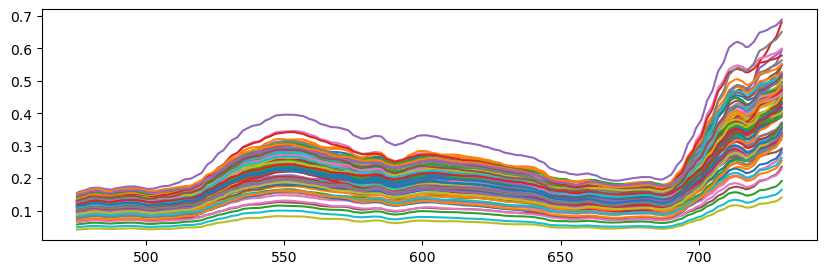

In [27]:
spectra.T.plot(figsize=(10,3),legend=False)

In [35]:
s_value=spectra.values

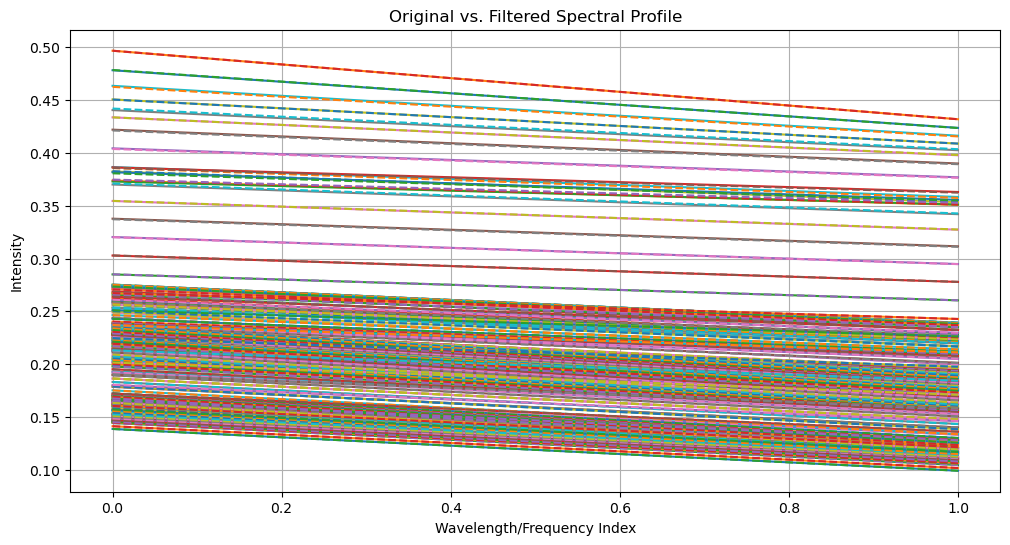

In [44]:
from scipy.signal import butter, filtfilt

# Design a Butterworth low-pass filter
def butter_lowpass_filter(data, cutoff_frequency, fs, order=5):
    """
    Apply a Butterworth low-pass filter to the given data.
    
    Parameters:
    - data: The input data to be filtered.
    - cutoff_frequency: The cutoff frequency of the low-pass filter.
    - fs: The sampling frequency of the data.
    - order: The order of the filter.
    
    Returns:
    - y: The filtered data.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Assume the sampling frequency fs is based on the inverse of the average spacing between wavelengths
# And a hypothetical cutoff frequency based on visual inspection of the frequency domain plot
fs = 1  # Simplification for this example
cutoff_frequency = 0.2 #pothetical cutoff frequency; needs to be chosen based on actual data analysis
i=[10,20]
# Apply the low-pass filter to the spectral profile
filtered_profile = butter_lowpass_filter(s_value[i], cutoff_frequency, fs, order=5)

# Plot the original and the filtered spectral profile for comparison
plt.figure(figsize=(12, 6))
plt.plot(s_value[i], label='Original Profile')
plt.plot(filtered_profile, label='Filtered Profile', linestyle='--')
plt.title('Original vs. Filtered Spectral Profile')
plt.xlabel('Wavelength/Frequency Index')
plt.ylabel('Intensity')

plt.grid(True)
plt.show()
